# 1. Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 2. Loading and Preprocessing the Data

In [ ]:
df = pd.read_csv('Data/clean.csv')
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

# 3. Defining Seasons and Extracting Year

In [ ]:
def assign_month(month):
    if month in [12, 1, 2]:
        return 'winter'
    if month in [6, 7, 8]:
        return 'summer'
    if month in [3, 4, 5]:
        return 'spring'
    else:
        return 'fall'
    
df['season'] = df['month'].apply(assign_month)

df['year'] = None
df.loc[(df['month'] == 12), 'year'] = df['date'].dt.year + 1
df.loc[~df['month'].isin([12]), 'year'] = df['date'].dt.year




In [8]:
df_season = df[df['season'].isin(['winter', 'summer'])]

# 4. Create mean value column for temperature and rain_sum

In [10]:
seasonal_stats = df_season.groupby(['City', 'season', 'year']).agg({
    'temperature_2m_mean': 'mean',
    'rain_sum': 'mean'
}).reset_index()

# 5. Seasonal Trends Analysis

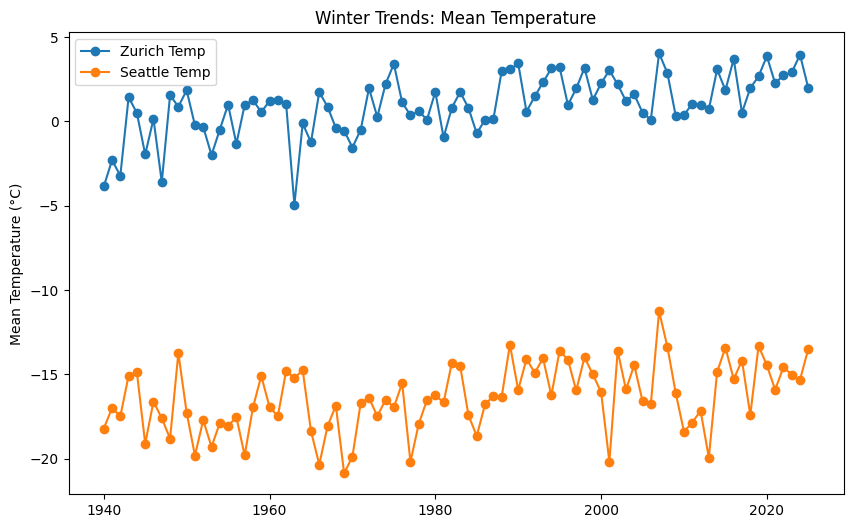

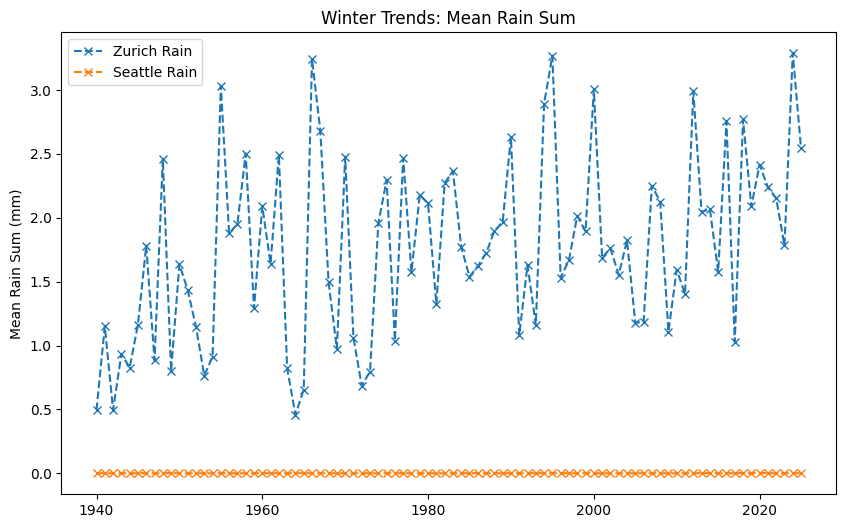

In [12]:
winter_stats = seasonal_stats[seasonal_stats['season'] == 'winter']

cities = ['Zurich', 'Seattle']
plt.figure(figsize=(10, 6))
for city in cities:
    city_data = winter_stats[winter_stats['City'] == city]
    plt.plot(city_data['year'], city_data['temperature_2m_mean'], marker = 'o', label = f'{city} Temp')
    

plt.title('Winter Trends: Mean Temperature')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for city in cities:
    city_data = winter_stats[winter_stats['City'] == city]
    plt.plot(city_data['year'], city_data['rain_sum'], marker = 'x', linestyle = '--', label = f'{city} Rain')
plt.title('Winter Trends: Mean Rain Sum')
plt.ylabel('Mean Rain Sum (mm)')
plt.legend()
plt.show()


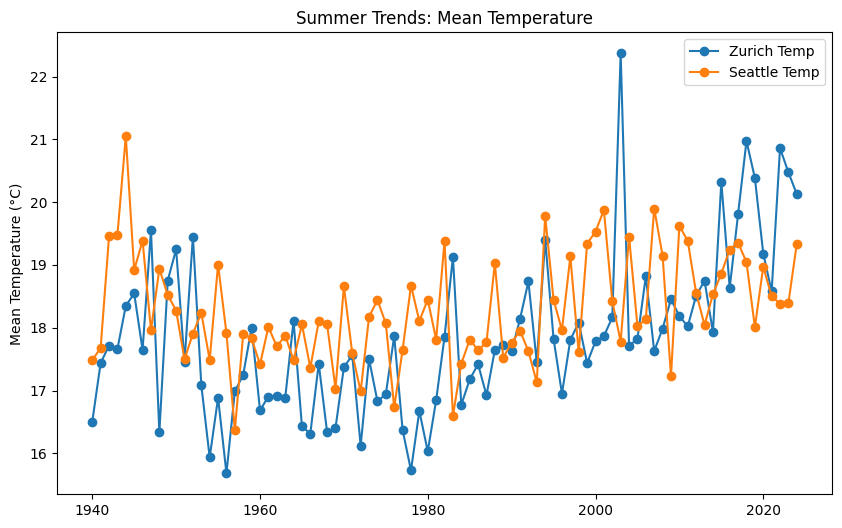

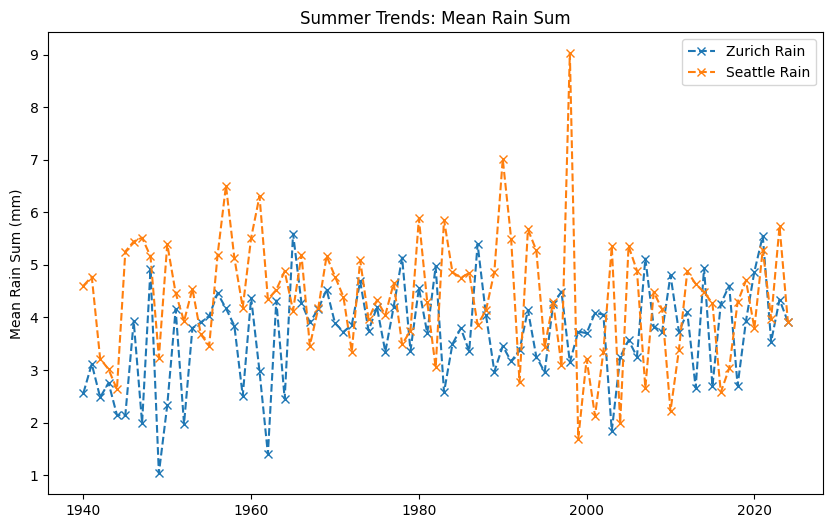

In [17]:
summer_stats = seasonal_stats[seasonal_stats['season'] == 'summer']

cities = ['Zurich', 'Seattle']
plt.figure(figsize=(10, 6))
for city in cities:
    city_data = summer_stats[summer_stats['City'] == city]
    plt.plot(city_data['year'], city_data['temperature_2m_mean'], marker = 'o', label = f'{city} Temp')
    

plt.title('Summer Trends: Mean Temperature')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for city in cities:
    city_data = summer_stats[summer_stats['City'] == city]
    plt.plot(city_data['year'], city_data['rain_sum'], marker = 'x', linestyle = '--', label = f'{city} Rain')
plt.title('Summer Trends: Mean Rain Sum')
plt.ylabel('Mean Rain Sum (mm)')
plt.legend()
plt.show()

# 7. Temperature Anomaly Calculation 

In [19]:
winter_stats['temperature_avg'] = winter_stats.groupby('City')['temperature_2m_mean'].transform('mean')
winter_stats['warmer_flag'] = np.where(winter_stats['temperature_2m_mean'] > winter_stats['temperature_avg'], 1, 0)
winter_stats['temp_anomaly'] = winter_stats['temperature_2m_mean'] - winter_stats['temperature_avg']

summer_stats['temperature_avg'] = summer_stats.groupby('City')['temperature_2m_mean'].transform('mean')
summer_stats['colder_flag'] = np.where(summer_stats['temperature_2m_mean'] < summer_stats['temperature_avg'], 1, 0)
summer_stats['temp_anomaly'] = summer_stats['temperature_2m_mean'] - summer_stats['temperature_avg']

C:\Users\nhatb\AppData\Local\Temp\ipykernel_12884\3675473399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_stats['temperature_avg'] = winter_stats.groupby('City')['temperature_2m_mean'].transform('mean')
C:\Users\nhatb\AppData\Local\Temp\ipykernel_12884\3675473399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_stats['warmer_flag'] = np.where(winter_stats['temperature_2m_mean'] > winter_stats['temperature_avg'], 1, 0)
C:\Users\nhatb\AppData\Local\Temp\ipykernel_12884\3675473399.py:3:

In [22]:
winter_corr_by_city = (
    winter_stats[winter_stats['warmer_flag'] == 1]
    .groupby('City')
    .apply(lambda x: x['temperature_2m_mean'].corr(x['rain_sum']))
)



C:\Users\nhatb\AppData\Local\Temp\ipykernel_12884\2196918930.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['temperature_2m_mean'].corr(x['rain_sum']))


In [23]:
summer_corr_by_city = (
    summer_stats[summer_stats['colder_flag'] == 1]
    .groupby('City')
    .apply(lambda x: x['temperature_2m_mean'].corr(x['rain_sum']))
)

C:\Users\nhatb\AppData\Local\Temp\ipykernel_12884\3124693000.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['temperature_2m_mean'].corr(x['rain_sum']))


In [24]:
summer_corr_by_city

City
Seattle   -0.139207
Zurich    -0.299142
dtype: float64

# 8. Correlation between warmer winter/ colder summer with rainfall

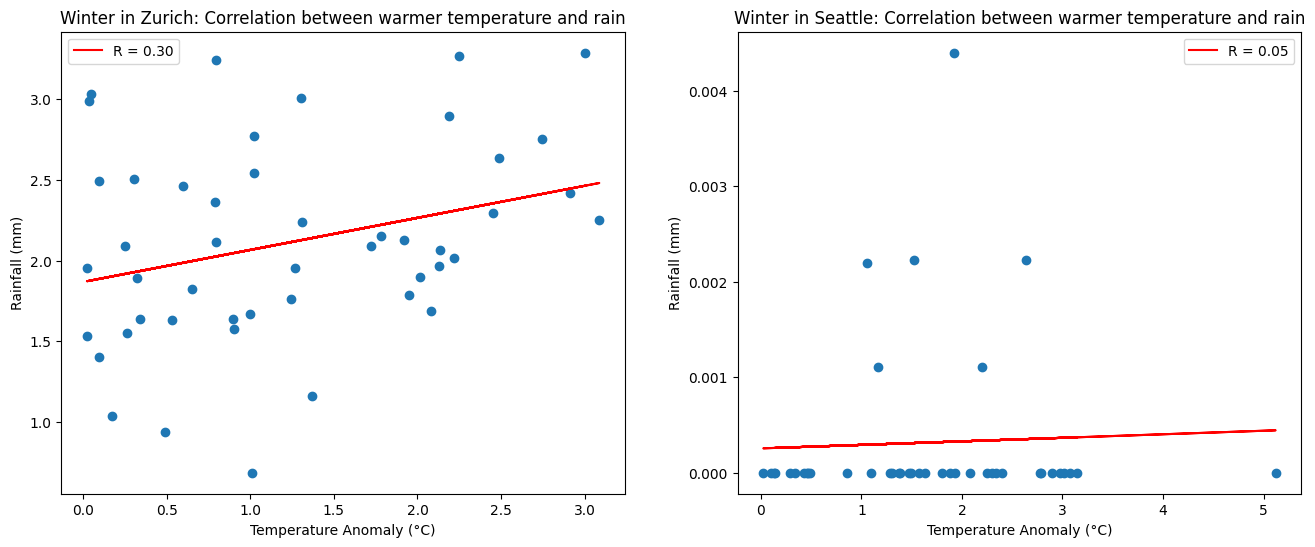

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plt.figure(figsize = (8,6))
x = winter_stats[(winter_stats['warmer_flag'] == 1) & (winter_stats['City'] == 'Zurich')]['temp_anomaly']
y = winter_stats[(winter_stats['warmer_flag'] == 1) & (winter_stats['City'] == 'Zurich')]['rain_sum']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
ax1.scatter(x,y)
ax1.plot(x, intercept + slope * x, 'r', label=f'R = {r_value:.2f}')
ax1.set_xlabel('Temperature Anomaly (°C)')
ax1.set_ylabel('Rainfall (mm)')
ax1.legend()
ax1.set_title('Winter in Zurich: Correlation between warmer temperature and rain')


plt.figure(figsize = (8,6))
a = winter_stats[(winter_stats['warmer_flag'] == 1) & (winter_stats['City'] == 'Seattle')]['temp_anomaly']
b = winter_stats[(winter_stats['warmer_flag'] == 1) & (winter_stats['City'] == 'Seattle')]['rain_sum']
slope, intercept, r_value, p_value, std_err = linregress(a, b)
ax2.scatter(a,b)
ax2.plot(a, intercept + slope * a, 'r', label=f'R = {r_value:.2f}')
ax2.set_xlabel('Temperature Anomaly (°C)')
ax2.set_ylabel('Rainfall (mm)')
ax2.legend()
ax2.set_title('Winter in Seattle: Correlation between warmer temperature and rain')


plt.tight_layout()
plt.show()

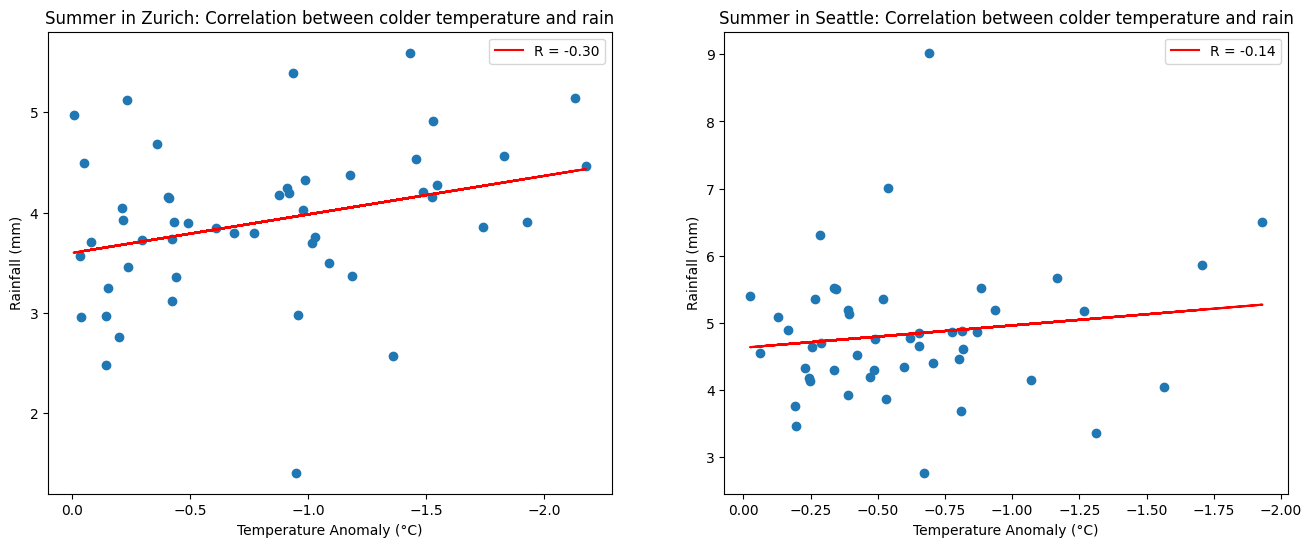

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [34]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 6))
ax3.invert_xaxis()
ax4.invert_xaxis()

plt.figure(figsize = (8,6))
c = summer_stats[(summer_stats['colder_flag'] == 1) & (summer_stats['City'] == 'Zurich')]['temp_anomaly']
d = summer_stats[(summer_stats['colder_flag'] == 1) & (summer_stats['City'] == 'Zurich')]['rain_sum']
slope, intercept, r_value, p_value, std_err = linregress(c, d)
ax3.scatter(c,d)
ax3.plot(c, intercept + slope * c, 'r', label=f'R = {r_value:.2f}')
ax3.set_xlabel('Temperature Anomaly (°C)')
ax3.set_ylabel('Rainfall (mm)')
ax3.legend()
ax3.set_title('Summer in Zurich: Correlation between colder temperature and rain')


plt.figure(figsize = (8,6))
e = summer_stats[(summer_stats['colder_flag'] == 1) & (summer_stats['City'] == 'Seattle')]['temp_anomaly']
f = summer_stats[(summer_stats['colder_flag'] == 1) & (summer_stats['City'] == 'Seattle')]['rain_sum']
slope, intercept, r_value, p_value, std_err = linregress(e, f)
ax4.scatter(e,f)
ax4.plot(e, intercept + slope * e, 'r', label=f'R = {r_value:.2f}')
ax4.set_xlabel('Temperature Anomaly (°C)')
ax4.set_ylabel('Rainfall (mm)')
ax4.legend()
ax4.set_title('Summer in Seattle: Correlation between colder temperature and rain')

plt.tight_layout()
plt.show()


# 9. The dependencies between weather features 

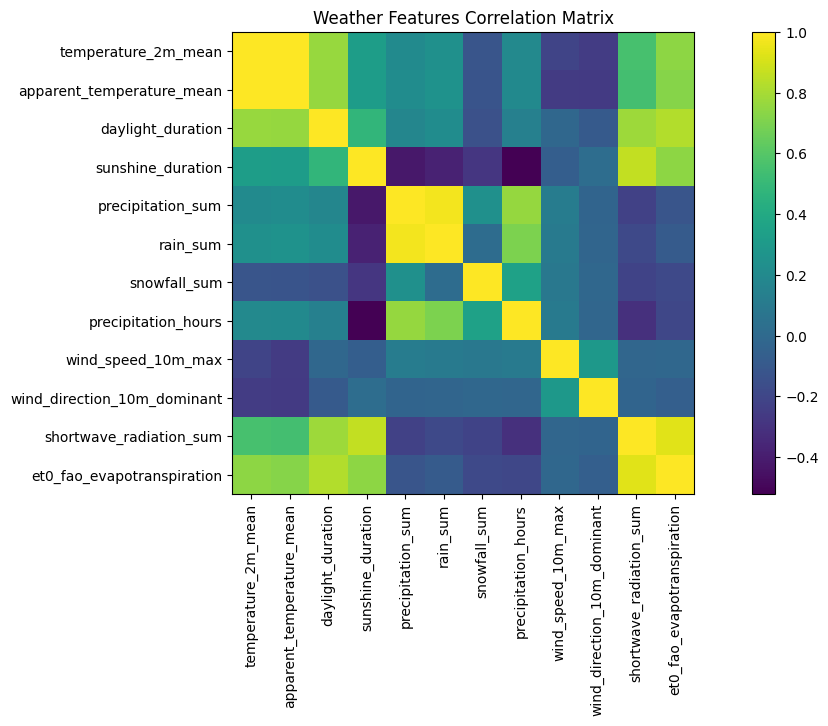

In [54]:
corr_matrix = df[['temperature_2m_mean', 'apparent_temperature_mean',
       'daylight_duration', 'sunshine_duration', 'precipitation_sum',
       'rain_sum', 'snowfall_sum', 'precipitation_hours', 'wind_speed_10m_max','wind_direction_10m_dominant',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration']].corr()

plt.figure(figsize=(15, 6))
plt.imshow(corr_matrix, cmap='viridis', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title('Weather Features Correlation Matrix')
plt.show()